# Wind Stress & Kinetic Energy — NEMO GYRE

- Wind stress quiver plot
- Total kinetic energy time series

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16, "axes.titlesize": 18, "axes.labelsize": 14})
import nc_time_axis  # noqa: F401 — registers cftime support in matplotlib
import numpy as np

from gyre import (
    load_output, load_mesh, interior_mask, cell_area, cell_volume,
    grid_angle, rotate_to_geo, gyre_map, DEPTH,
)

OUTPUT_DIR = Path("../output")

ds_t = load_output("*_grid_T.nc", OUTPUT_DIR)
ds_u = load_output("*_grid_U.nc", OUTPUT_DIR)
ds_v = load_output("*_grid_V.nc", OUTPUT_DIR)
mesh = load_mesh(OUTPUT_DIR)

tmask = mesh["tmask"]
interior = interior_mask(tmask.isel(nav_lev=0))
area = cell_area(mesh)
cell_vol = cell_volume(mesh, tmask)
angle = grid_angle(mesh)

## Wind stress

Time-mean wind stress vectors (`sozotaux`, `sometauy`) overlaid on
wind stress magnitude.

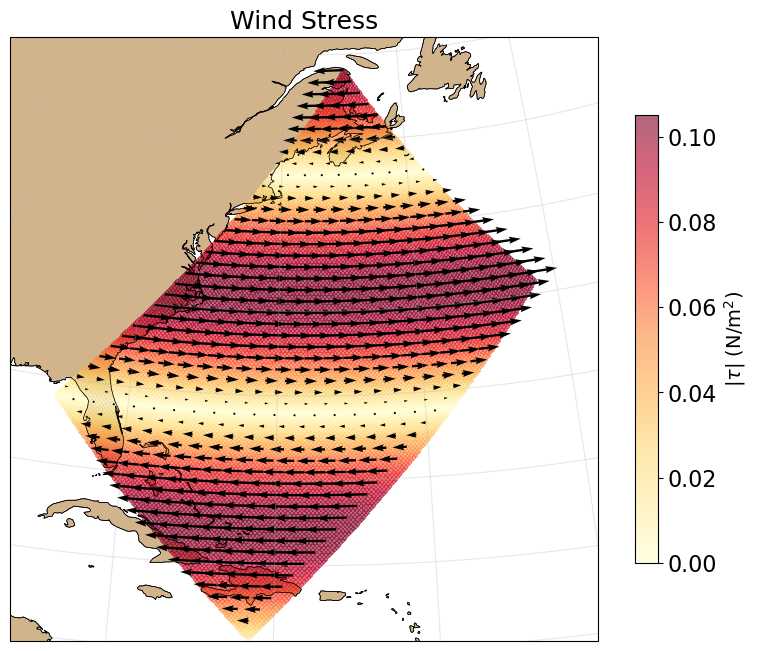

In [2]:
taux_i = ds_t["sozotaux"].mean("time_counter")
tauy_j = ds_t["sometauy"].mean("time_counter")

# Rotate from grid (i,j) to geographic (east, north)
taux_east, tauy_north = rotate_to_geo(taux_i, tauy_j, angle)

tau_mag = np.sqrt(taux_east**2 + tauy_north**2).where(interior)

fig, ax = gyre_map(ds=ds_t)

pcm = ax.pcolormesh(
    ds_t.nav_lon.values, ds_t.nav_lat.values, tau_mag.values,
    shading="auto", cmap="YlOrRd",
    alpha=0.6, transform=ccrs.PlateCarree(),
)
fig.colorbar(pcm, ax=ax, label="|$\\tau$| (N/m$^2$)", shrink=0.7)

skip = 5
te = taux_east.where(interior).values
tn = tauy_north.where(interior).values
ax.quiver(
    ds_t.nav_lon.values[::skip, ::skip], ds_t.nav_lat.values[::skip, ::skip],
    te[::skip, ::skip], tn[::skip, ::skip],
    color="k", scale=2.0, width=0.004, transform=ccrs.PlateCarree(),
)
ax.set_title("Wind Stress")
fig.tight_layout()
fig.savefig("../figures/wind_stress.png", dpi=150, bbox_inches="tight")

## Total kinetic energy time series

Volume-integrated KE: $\text{KE} = \frac{1}{2}\rho_0 \sum_{i,j,k}
(u^2 + v^2)\, e1t\, e2t\, e3t\, \text{tmask}$

U and V are interpolated to the T-grid (simple average of neighbours)
before computing KE.

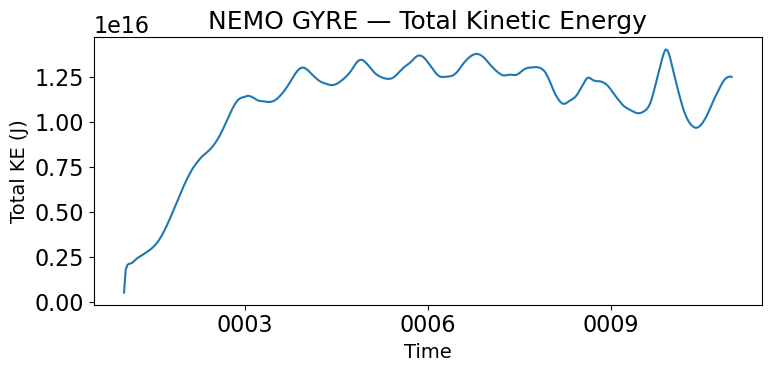

In [3]:
rho0 = 1026.0

# Interpolate U to T-grid: average of u(x) and u(x+1)
u = ds_u["vozocrtx"]
v = ds_v["vomecrty"]
u_on_t = 0.5 * (u + u.shift(x=-1))

# Interpolate V to T-grid: average of v(y) and v(y+1)
v_on_t = 0.5 * (v + v.shift(y=-1))

# Trim all to common interior (drop boundary ring with NaN from shift)
s = dict(y=slice(1, -1), x=slice(1, -1))
u2 = u_on_t.isel(**s) ** 2
v2 = v_on_t.isel(**s) ** 2
cv = cell_vol.isel(**s)

# Total KE = ½ ρ₀ Σ (u² + v²) dV  (vectorised over time)
ke = 0.5 * rho0 * ((u2 + v2) * cv).sum([DEPTH, "y", "x"])

fig, ax = plt.subplots(figsize=(8, 4))
ke.plot.line(ax=ax, x="time_counter")
ax.set_xlabel("Time")
ax.set_ylabel("Total KE (J)")
ax.set_title("NEMO GYRE — Total Kinetic Energy")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
fig.tight_layout()